In [1]:
import numpy as np
import pandas as pd
import uproot
import seaborn as sns

import matplotlib.pyplot as plt
dirOutPath = '/data/Skim/'

## Load signal + MC

In [3]:
SignalFlat = [0]*4
for i in range(1,5):
    SignalFlat[i-1] = uproot.open(dirOutPath + 'SignalFlat{}.root:Events'.format(i)).arrays(library='pd')
    SignalFlat[i-1]['label'] = 'signal'

#SignalFlat[0] = SignalFlat[0].rename(columns={'mu_pt0':'lep_pt0', 'mu_pt1':'lep_pt1', 'mu_mass0':'lep_mass0',
                             #'mu_mass1':'lep_mass1', 'mu_q0':'lep_q0', 'mu_q1':'lep_q1'})

#SignalFlat[1] = SignalFlat[1].rename(columns={'mu_pt':'lep_pt0', 'el_pt':'lep_pt1', 'mu_mass':'lep_mass0',
                             #'el_mass':'lep_mass1', 'mu_q':'lep_q0', 'el_q':'lep_q1'})

#SignalFlat[2] = SignalFlat[2].rename(columns={'mu_pt0':'lep_pt0', 'mu_pt1':'lep_pt1', 'mu_pt2':'lep_pt2',
                                              #'mu_mass0':'lep_mass0', 'mu_mass1':'lep_mass1', 'mu_mass2':'lep_mass2',
                                              #'mu_q0':'lep_q0', 'mu_q1':'lep_q1', 'mu_q2':'lep_q2'})

diLepton = pd.concat((SignalFlat[0], SignalFlat[1]))
triLepton = pd.concat((SignalFlat[2], SignalFlat[3]))

In [4]:
MCFlat = [0]*4
for i in range(1,5):
    MCFlat[i-1] = uproot.concatenate(dirOutPath + 'MC*{}.root:Events'.format(i), allow_missing=True, library='pd')
    MCFlat[i-1]['label'] = 'bkg'

MCFlat[0] = MCFlat[0].rename(columns={'mu_pt0':'lep_pt0', 'mu_pt1':'lep_pt1', 'mu_mass0':'lep_mass0',
                             'mu_mass1':'lep_mass1', 'mu_q0':'lep_q0', 'mu_q1':'lep_q1'})

MCFlat[1] = MCFlat[1].rename(columns={'mu_pt':'lep_pt0', 'el_pt':'lep_pt1', 'mu_mass':'lep_mass0',
                             'el_mass':'lep_mass1', 'mu_q':'lep_q0', 'el_q':'lep_q1'})

MCFlat[2] = MCFlat[2].rename(columns={'mu_pt0':'lep_pt0', 'mu_pt1':'lep_pt1', 'mu_pt2':'lep_pt2',
                                              'mu_mass0':'lep_mass0', 'mu_mass1':'lep_mass1', 'mu_mass2':'lep_mass2',
                                              'mu_q0':'lep_q0', 'mu_q1':'lep_q1', 'mu_q2':'lep_q2'})

diLepton = pd.concat((diLepton, MCFlat[0], MCFlat[1]))
triLepton = pd.concat((triLepton, MCFlat[2], MCFlat[3]))

# triLepton = triLepton.dropna(how='any')

In [5]:
MCFlat[3][np.isnan(MCFlat[3]['inv_m12'])]

,inv_m02,Jet_pt1,bJet_pt0,lep_mass2,dPhi2,dR02,lep_pt0,lep_mass1,eventWeightLumi,MET_pt,...,nBJ,dR01,lep_mass0,dR1J,dPhi1,Jet_pt0,inv_m3,lep_pt2,dPhi0,label


In [18]:
len(MCFlat[2])

62700

In [8]:
provaMC = uproot.open(dirOutPath + 'MCtZqFlat3.root:Events').arrays(library='pd')
provaMC['label']='bkg'

provaMC = provaMC.rename(columns={'mu_pt0':'lep_pt0', 'mu_pt1':'lep_pt1', 'mu_pt2':'lep_pt2',
                                              'mu_mass0':'lep_mass0', 'mu_mass1':'lep_mass1', 'mu_mass2':'lep_mass2',
                                              'mu_q0':'lep_q0', 'mu_q1':'lep_q1', 'mu_q2':'lep_q2'})

In [9]:
prova_set = pd.concat((provaMC, SignalFlat[2]))

X_train_, X_test_, y_train_, y_test_ = train_test_split(prova_set.loc[:, prova_set.columns != 'label'], prova_set['label'],
                                                    test_size=0.2, random_state=1234)

In [10]:
provaTree = gbc() 
provaTree.fit(X_train_, y_train_)

GradientBoostingClassifier()

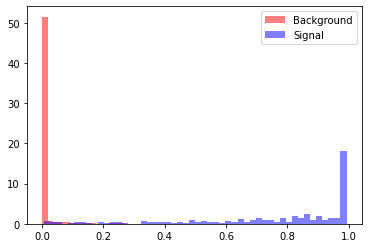

In [12]:
predict_ = provaTree.predict_proba(X_test_)
#predict2 = diLeptonTree.predict_proba(diLepton.loc[:, diLepton.columns != 'label'])
#predict2 = diLeptonTree.predict_proba(X_train2)

signal_, bkg_ = [],[]

for a,b in zip(predict_[:,1], y_test_):
    if b=='signal':
        signal_.append(a)
    elif b=='bkg':
        bkg_.append(a)

plt.hist(bkg_, color='red', bins=50, label='Background', density=True, alpha=.5)
plt.hist(signal_, color='blue', bins=50, label='Signal', density=True, alpha=.5)
plt.legend()
plt.show()

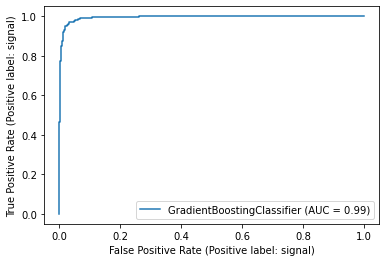

In [15]:
plot_roc_curve(provaTree, X_test_, y_test_)
plt.show()

## Correlations

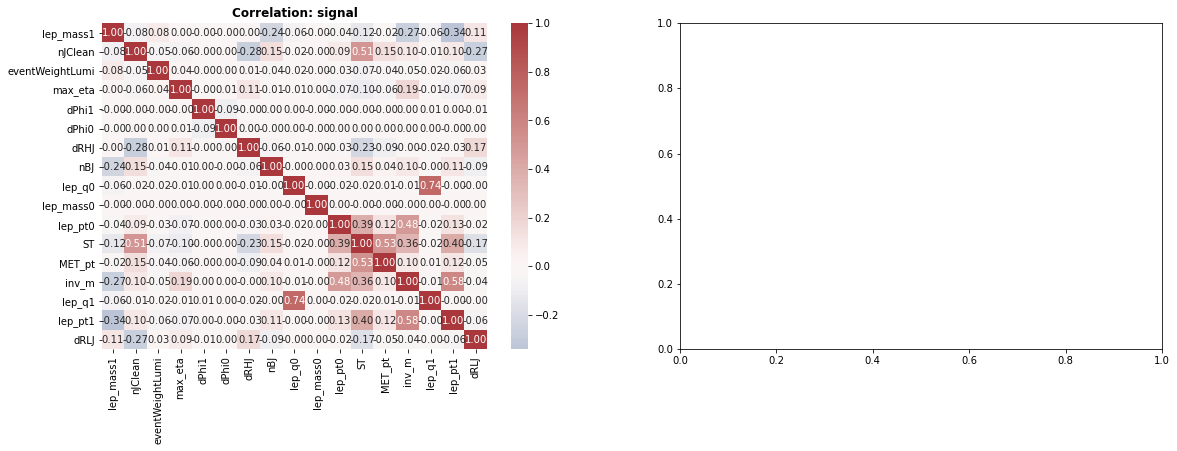

In [4]:
sgn_corr = diLepton.corr()


f_corr, (ax_sgn_corr, ax_bkg_corr) = plt.subplots(nrows=1, ncols=2, figsize=(19, 6))
ax_sgn_corr.set_title('Correlation: signal', fontweight="bold")
tabc_sgn = sns.heatmap(sgn_corr, center=0, cmap='vlag', annot=True, fmt='.2f', linewidths=0,
            xticklabels=sgn_corr.columns.values,
            yticklabels=sgn_corr.columns.values, ax=ax_sgn_corr)

f_corr.show()

## Train BDT

In [5]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.metrics import plot_roc_curve

X_train2, X_test2, y_train2, y_test2 = train_test_split(diLepton.loc[:, diLepton.columns != 'label'], diLepton['label'],
                                                    test_size=0.2, random_state=1234567)

X_train3, X_test3, y_train3, y_test3 = train_test_split(triLepton.loc[:, triLepton.columns != 'label'], triLepton['label'],
                                                    test_size=0.2, random_state=1234)

# kf = KFold(n_splits=5)

# for train_index, test_index in kf.split(X, y):
#     xgb_model = xgb.XGBRFRegressor(random_state=42).fit(
#     X[train_index], y[train_index])

### Di-Lepton category

In [9]:
diLeptonTree = gbc() 
diLeptonTree.fit(X_train2, y_train2)

GradientBoostingClassifier()

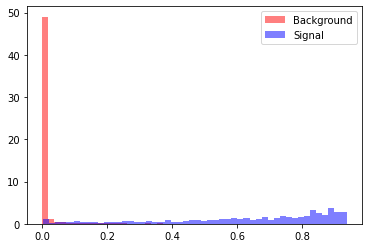

In [14]:
predict2 = diLeptonTree.predict_proba(X_test2)
#predict2 = diLeptonTree.predict_proba(diLepton.loc[:, diLepton.columns != 'label'])
#predict2 = diLeptonTree.predict_proba(X_train2)

signal2, bkg2 = [],[]

for a,b in zip(predict2[:,1], y_test2):
    if b=='signal':
        signal2.append(a)
    elif b=='bkg':
        bkg2.append(a)

plt.hist(bkg2, color='red', bins=50, label='Background', density=True, alpha=.5)
plt.hist(signal2, color='blue', bins=50, label='Signal', density=True, alpha=.5)
plt.legend()
plt.show()

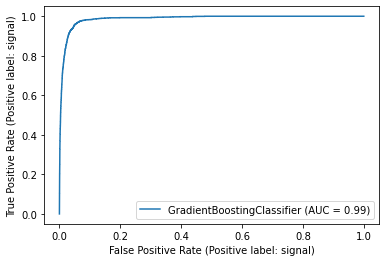

In [15]:
plot_roc_curve(diLeptonTree, X_test2, y_test2)
plt.show()

### Tri-Lepton category

In [5]:
triLeptonTree = gbc()
triLeptonTree.fit(X_train3, y_train3)

GradientBoostingClassifier()

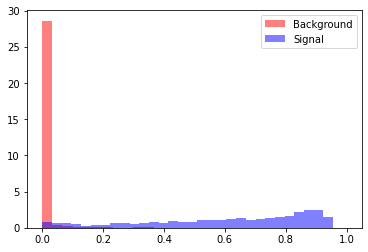

In [8]:
predict3 = triLeptonTree.predict_proba(X_test3)

signal3, bkg3 = [],[]

for a,b in zip(predict3[:,1], y_test3):
    if b=='signal':
        signal3.append(a)
    elif b=='bkg':
        bkg3.append(a)

plt.hist(bkg3, color='red', bins=30, label='Background', density=True, alpha=.5)
plt.hist(signal3, color='blue', bins=30, label='Signal', density=True, alpha=.5)
plt.legend()
plt.show()

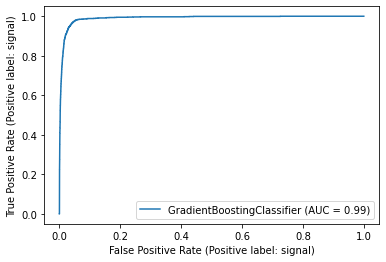

In [9]:
plot_roc_curve(triLeptonTree, X_test3, y_test3)
plt.show()

## Load Data + statistics

In [17]:
DataFlat = [0]*4
for i in range(1,5):
    DataFlat[i-1] = uproot.open(dirOutPath + 'DataFlat{}.root:Events'.format(i)).arrays(library='pd')

    
DataFlat[0] = DataFlat[0].rename(columns={'mu_pt0':'lep_pt0', 'mu_pt1':'lep_pt1', 'mu_mass0':'lep_mass0',
                             'mu_mass1':'lep_mass1', 'mu_q0':'lep_q0', 'mu_q1':'lep_q1'})

DataFlat[1] = DataFlat[1].rename(columns={'mu_pt':'lep_pt0', 'el_pt':'lep_pt1', 'mu_mass':'lep_mass0',
                             'el_mass':'lep_mass1', 'mu_q':'lep_q0', 'el_q':'lep_q1'})

DataFlat[2] = DataFlat[2].rename(columns={'mu_pt0':'lep_pt0', 'mu_pt1':'lep_pt1', 'mu_pt2':'lep_pt2',
                                              'mu_mass0':'lep_mass0', 'mu_mass1':'lep_mass1', 'mu_mass2':'lep_mass2',
                                              'mu_q0':'lep_q0', 'mu_q1':'lep_q1', 'mu_q2':'lep_q2'})

diLeptonData = pd.concat((DataFlat[0], DataFlat[1]))
triLeptonData = pd.concat((DataFlat[2], DataFlat[3]))

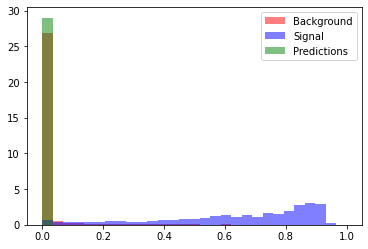

In [31]:
predict_data2 = diLeptonTree.predict_proba(diLeptonData.sample(frac=0.2))[:,1]
bams = np.linspace(0,1,30)

b, _, _ = plt.hist(bkg2, color='red', bins=bams, label='Background', density=True, alpha=.5)
s, _, _ = plt.hist(signal2, color='blue', bins=bams, label='Signal', density=True, alpha=.5)
d, _, _ = plt.hist(predict_data2, color='green', bins=bams, label='Predictions', density=True, alpha=.5)
plt.legend()
plt.show()

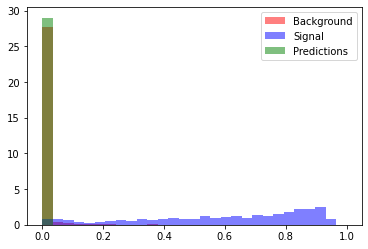

In [26]:
predict_data3 = triLeptonTree.predict_proba(triLeptonData)[:,1]
bams = np.linspace(0,1,30)

b, _, _ = plt.hist(bkg3, color='red', bins=bams, label='Background', density=True, alpha=.5)
s, _, _ = plt.hist(signal3, color='blue', bins=bams, label='Signal', density=True, alpha=.5)
d, _, _ = plt.hist(predict_data3, color='green', bins=bams, label='Predictions', density=True, alpha=.5)
plt.legend()
plt.show()

In [32]:
from scipy.stats import poisson as ps

np.random.seed(12345)

mu_grid = np.arange(0, 3, 1e-3)

b_plus_sig = np.outer(s, mu_grid) + np.tile(b,(len(mu_grid),1)).T
b_plus_sig.shape
like_grid = np.sum(np.log(ps.pmf(np.tile(d,(len(mu_grid),1)).T, b_plus_sig)), axis=0)

In [35]:
like_grid

array([ -3.99580186,  -4.02396893,  -4.05213603, ..., -88.51413065,
       -88.54236374, -88.57059685])

In [30]:
def stat(data, bkg, sig):
    
    import scipy as sp
    from scipy.stats import poisson as ps
    
    np.random.seed(12345)
    mu_grid = np.arange(0, 3, 1e-3)
    
    b_plus_sig = np.outer(sig, mu_grid) + np.tile(bkg,(len(mu_grid),1)).T
    
    like_grid = - np.sum(np.log(ps.pmf(np.tile(data,(len(mu_grid),1)).T, b_plus_sig)), axis=0)
    mu_best = mu_grid[np.argmax(like_grid)]
    b_plus_sig_best = bkg + sig*mu_best
    print(mu_best)
    plt.plot(mu_grid, like_grid)
    return
    
    nbins = len(data)
    ntoys = int(1e5)
    bin_toys = 1000
    
    mu_min = mu_best+1e-7
    mu_max = mu_best+1
    #mus = mu_best+np.arange(1e-7,2,0.1)
    #CL = []
    #significance = []
    for i in range(5):
        mu = (mu_min+mu_max)/2
        
        b_plus_sig_mu = bkg + sig*mu
        toys = ps.rvs(np.tile(b_plus_sig_mu,(ntoys,1)).T, size=(nbins,ntoys))
        
        like_num0 = np.sum(np.log(ps.pmf(toys, np.tile(bkg,(ntoys,1)).T)), axis=0)
        like_num1 = np.sum(np.log(ps.pmf(toys, np.tile(b_plus_sig_mu,(ntoys,1)).T)), axis=0)
        like_den = np.sum(np.log(ps.pmf(toys, np.tile(b_plus_sig_best,(ntoys,1)).T)), axis=0)
    
        q_mu0 = -2 * (like_num0 - like_den)
        q_mu1 = -2 * (like_num1 - like_den)
        
        like_num_obs = np.sum(np.log(ps.pmf(data, b_plus_sig_mu)))
        like_den_obs = np.sum(np.log(ps.pmf(data, b_plus_sig_best)))
        q_mu_obs = -2 * (like_num_obs - like_den_obs)
        
        
        ### H0 ###
        values_0, bins_0, _ = plt.hist(q_mu0, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_0 > q_mu_obs)
        p_b = sum(np.diff(bins_0[mask])*values_0[mask[:-1]])
        
        ### H1 ###
        values_1, bins_1, _ = plt.hist(q_mu1, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_1 > q_mu_obs)
        p_mu = sum(np.diff(bins_1[mask])*values_1[mask[:-1]])
        
        
        if p_b == 0:
            mu_max = mu
            continue
        
        #CL.append(p_mu/p_b)
        #significance.append(-sp.stats.norm.ppf(p_b))
        
        CL = p_mu/p_b
        
        if CL < 0.05:
            mu_max = mu
        else:
            mu_min = mu
            
    plt.hist(q_mu0, bins=bin_toys, alpha=0.5, color='red', density=True)
    plt.hist(q_mu1, bins=bin_toys, alpha=0.5, color='blue', density=True)
    #plt.xlim((-70,10))
    plt.ylim((0,0.3))
    plt.plot([q_mu_obs, q_mu_obs], [0, 10000], color='#00A88F')
    plt.show()
            
    significance = -sp.stats.norm.ppf(p_b)
        
    return mu, CL, significance
        

2.999


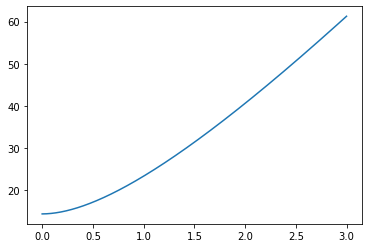

In [31]:
stat(d, b, s)

In [ ]:
plt.figure(figsize=(8,6))

plt.hist(
    siLepton
)

plt.errorbar(
    bin_centers, data_counts, yerr=np.sqrt(data_counts),
    fmt='o', ms=4, lw=1, color='black', label='Data', capsize=3
)

plt.hist(
    bin_centers, weights=SigMC_counts*mu, bins=edges,
    label='MCSig', color='#00A88F', alpha=1.,  histtype=u'step', linewidth=2
)

plt.xlabel(variable)
plt.ylabel('counts')

ST_patch = patches.Patch(color=bkg_colors[0], label='Single Top')
TT_patch = patches.Patch(color=bkg_colors[1], label='Top Top')
TTW_patch = patches.Patch(color=bkg_colors[5], label=r'tt$\rightarrow$ W')
TTZ_patch = patches.Patch(color=bkg_colors[6], label=r'tt$\rightarrow$ Z')
Diboson_patch = patches.Patch(color=bkg_colors[7], label='Diboson')
Others_patch = patches.Patch(color=bkg_colors[-1], label='Others')
MCSig_patch = patches.Patch(color='#00A88F', label='MCSig')
Data = Line2D([0], [0], marker='o', color='w', label='Data', markerfacecolor='black', markersize=7)

plt.legend(handles=[ST_patch,TT_patch, TTW_patch, TTZ_patch, Diboson_patch, Others_patch, MCSig_patch, Data])
plt.tight_layout()

plt.show()

